# Generating samples from 1-D Gaussian

Adapted from https://github.com/ericjang/genadv_tutorial/blob/master/genadv1.ipynb.

## Development environment
Let's start with setting up our development environment by loading the necessary libraries.

Instead of standard TensorFlow, we will use the recently released "eager execution". This provides define-by-run access to most of the standard TensorFlow API. Details about eager execution can be found in this Google Research blog post [link text](https://research.googleblog.com/2017/10/eager-execution-imperative-define-by.html).

At the time of writing, the latest stable release of TensorFlow is 1.4.1 which does not include the eager functionality. Therefore, we install the nightly build before continuing.

In [0]:
! pip install -Uq tf-nightly

We first import TensorFlow as usual and then import `tensorflow.contrib.eager` and enable eager execution.

The other dependencies for this notebook are NumPy and some packages for plotting.

In [2]:
# Import TensorFlow
import tensorflow as tf
print("Running TensorFlow version " + tf.__version__)
# Define by run 🎉 (https://research.googleblog.com/2017/10/eager-execution-imperative-define-by.html)
import tensorflow.contrib.eager as tfe
tfe.enable_eager_execution()

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns # for pretty plots
from scipy.stats import norm
from IPython import display
%matplotlib inline

Running TensorFlow version 1.5.0-dev20171227


## Target distribution $p_{data}$
This is the distribution that our generator should model. We define this $p_{data}$ as a Gaussian with mean $\mu = -1$ and variance $\sigma^2 = 1$.

In [0]:
mean, variance = -1, 1

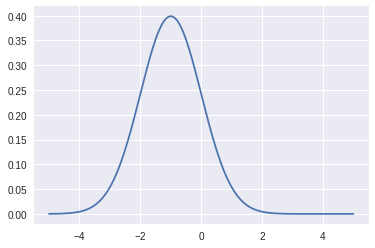

In [4]:
xs = np.linspace(-5, 5, 1000)
plt.plot(xs, norm.pdf(xs, loc=mean, scale=variance))

## Model used for generator and discriminator
We'll use an MLP with `tanh` activations and one hidden layer of 30 neurons, inspired by https://cs.stanford.edu/people/karpathy/gan/. Our generator and discriminator will both be an instance of the same MLP class.

In [0]:
class MLP(tfe.Network):
  def __init__(self):
    super(MLP, self).__init__()
    self.layer1 = self.track_layer(tf.layers.Dense(units=30, activation=tf.nn.tanh))
    self.layer2 = self.track_layer(tf.layers.Dense(units=1, activation=tf.nn.tanh))
    
  def call(self, input):
    """Actually runs the model."""
    result = self.layer1(input)
    result = self.layer2(result)
    return result

It is now an appropriate time to set some hyperparameters.

In [0]:
TRAIN_ITERS = 20000
# Minibatch size
M = 200

## Pre-train decision surface

Before defining our adversarial play, we'll fit the discriminator network to the training data in hopes of faster convergence.

We will train the discriminator using a momentum optimizer:

In [0]:
batch = tfe.Variable(0)
learning_rate = tf.train.exponential_decay(
  0.001,  # Base learning rate.
  batch,  # Current index into the dataset.
  TRAIN_ITERS // 4,  # Decay step - this decays 4 times throughout training process.
  0.95,  # Decay rate.
  staircase=True)
discriminator_optimizer=tf.train.MomentumOptimizer(learning_rate, 0.6)

Let's create the discriminator as an instance of our MLP class,

In [0]:
with tf.variable_scope("D"):
  D = MLP()

and define a helper function which will illustrate the current output of our networks.

In [0]:
def plot_fig(D=None, G=None):
  f, ax = plt.subplots(1)

  r = 5000 # resolution (number of points)
  
  # Plot p_data
  xs = np.linspace(-5, 5, r)
  ax.plot(xs, norm.pdf(xs, loc=mean, scale=variance), label='p_data')
  
  if D:
    # Forward propagate points from x-axis through discriminator
    discriminator_output = np.zeros((r,1)) # decision surface
    discriminator_output[:] = D(tf.constant(np.reshape(xs, (r,1))))
    discriminator_output[:] = tf.maximum(tf.minimum(discriminator_output,.99), 0.01) # clamp as a probability

    # Plot discriminator output
    ax.plot(xs, discriminator_output, label='decision boundary')
  
  if G:
    # Forward propagate samples from noise prior through generator
    zs = np.linspace(-5, 5, r)
    gs = np.zeros((r, 1)) # generator function
    z = tf.constant(np.reshape(zs, (r, 1)))
    generated_samples = G(z)
    generated_samples = tf.multiply(5.0, generated_samples) # scale up by 5 to match range
    gs[:] = generated_samples

    # Plot distribution of inverse-mapped points
    histc, edges = np.histogram(gs, bins = 10)
    ax.plot(np.linspace(-5, 5, 10), histc / float(r), label='p_g')
  
  ax.set_ylim(0, 1.1)
  plt.legend()

Let's use our helper function to plot the initial discriminator output (clamped as probability; between 0 and 1) which is dependent on the initialization of our network's parameters. Therefore, it probably won't be very meaningful at this point.

Text(0.5,1,'Initial Decision Boundary')

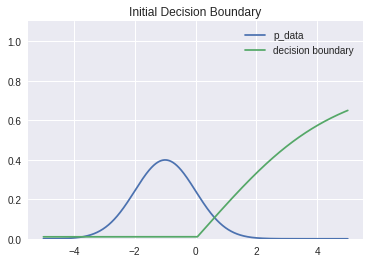

In [10]:
plot_fig(D)
plt.title('Initial Decision Boundary')

We now fit the discriminator to our data distribution and plot the result.

In [0]:
def mse_loss(model, x, y):
  y_ = model(x)
  return tf.losses.mean_squared_error(y, y_)

In [0]:
FIT_ITERS = 3000
loss_history = np.zeros(FIT_ITERS)

for i in range(FIT_ITERS):
  # Sample batch from data distribution
  d = (np.random.random(M)-0.5) * 10.0 # instead of sampling only from gaussian, want the domain to be covered as uniformly as possible
  labels = norm.pdf(d, loc=mean, scale=variance)

  # Shape batch samples
  x = np.reshape(d, (M,1))
  y = np.reshape(labels, (M, 1))
  
  # Compute all partial derivatives of the MSE loss
  loss_history[i], grads_and_vars = tfe.implicit_value_and_gradients(mse_loss)(D, x, y)

  # Optimize
  discriminator_optimizer.apply_gradients(grads_and_vars, global_step=batch)

Text(0.5,1,'Training Loss')

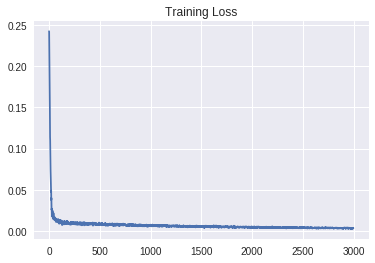

In [13]:
plt.plot(loss_history)
plt.title('Training Loss')

Text(0.5,1,'Discriminator after fitting to p_data')

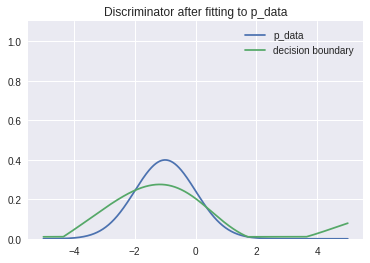

In [14]:
plot_fig(D)
plt.title('Discriminator after fitting to p_data')

## Generative adversarial network

### Instantiating generator network
We now instantiate an MLP object which we'll use as our generator.

In [0]:
with tf.variable_scope("G"):
  G = MLP()

Again, we'll train the network using momentum:

In [0]:
batch_g = tfe.Variable(0)
learning_rate = tf.train.exponential_decay(
  0.001,  # Base learning rate.
  batch_g,  # Current index into the dataset.
  TRAIN_ITERS // 4,  # Decay step - this decays 4 times throughout training process.
  0.95,  # Decay rate.
  staircase=True)
opt_g=tf.train.MomentumOptimizer(learning_rate, 0.6)

Let's see what the situation looks like before training.

Text(0.5,1,'Before Training')

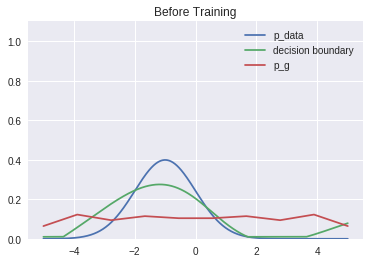

In [17]:
plot_fig(D, G)
plt.title('Before Training')

### Defining the zero-sum game
We define the value function (loss) as in *Goodfellow et al. (2016)*:
$$ v(\boldsymbol{\theta}^{(g)}, \boldsymbol{\theta}^{(d)}) = \mathbb{E}_{x\sim p_{data}} \log d(\boldsymbol{x}) + \mathbb{E}_{x\sim p_{model}} \log (1 - d(\boldsymbol{x})).$$

The discriminator and generator will play a zero-sum game. The discriminator will try to maximize this value function, while the generator tries to minimize it.

In [0]:
def value_function(D, G, x, z):
  # D(x), x sampled from data distribution
  p_norm_data = D(x) # output likelihood of being normally distributed
  D1 = tf.maximum(tf.minimum(p_norm_data, .99), 0.01) # clamp as a probability

  # D(x), x sampled from model distribution as G(z)
  generated_samples = G(z)
  generated_samples = tf.multiply(5.0, generated_samples)
  p_norm_gen = D(generated_samples)
  D2 = tf.maximum(tf.minimum(p_norm_gen, .99), 0.01)
  
  # v(\theta^g, \theta^d)
  loss = tf.reduce_mean(tf.log(D1) + tf.log(1 - D2))
  return loss

def neg_value_function(D, G, x, z):
  '''Because our optimizers will minimize the loss function passed in,
  we define the _negative_ value function.
  
  Instead of maximizing the value function, 
  the discriminator will minimize this _negative_ value function.
  '''
  return -value_function(D, G, x, z)

### Ready, set, GO!

Some helpers for drawing samples from data and noise prior, respectively.

In [0]:
def sample_data(batch_size=200):
  x = np.random.normal(mean, variance, batch_size)
  x.sort()
  x = tf.constant(np.reshape(x, (batch_size, 1)))
  return x

def sample_noise_prior(batch_size=200):
  z = np.linspace(-5.0, 5.0, M) + np.random.random(M) * 0.01
  z = tf.constant(np.reshape(z, (M, 1)))
  return z

Optimize generator and discriminator networks.

0.995


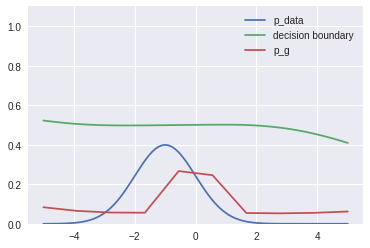

In [20]:
# Algorithm 1 of Goodfellow et al. (2014)

# Number of discriminator updates per epoch
k = 5
# Setup log of loss throughout training
histd, histg = np.zeros(TRAIN_ITERS), np.zeros(TRAIN_ITERS)

for i in range(TRAIN_ITERS):
  # Train discriminator.
  for j in range(k):
    ## 1) Sample data,
    x = sample_data(batch_size=M)
    
    ## 2) Sample noise prior,
    z = sample_noise_prior(batch_size=M)

    ## 3) Compute all partial derivatives of the loss function,
    histd[i], grads_and_vars = tfe.implicit_value_and_gradients(neg_value_function)(D, G, x, z)
    
    ## 4) Optimize discriminator, and not generator (!).
    discriminator_grads_and_vars = [gv for gv in grads_and_vars if gv[1].name.startswith('D/')]
    discriminator_optimizer.apply_gradients(discriminator_grads_and_vars, global_step=batch)

  # Train generator.
  ## 1) Sample noise prior,
  z = sample_noise_prior(batch_size=M)
  
  ## 2) Compute all partial derivatives of the loss function
  histg[i], grads_and_vars = tfe.implicit_value_and_gradients(value_function)(D, G, x, z)
  
  ## 3) Optimize generator, and not discriminator (!)
  generator_grads_and_vars = [gv for gv in grads_and_vars if gv[1].name.startswith('G/')]
  opt_g.apply_gradients(generator_grads_and_vars, global_step=batch)

  # Illustrate current situation.
  if i % 100 == 0:
    print(float(i) / float(TRAIN_ITERS))
    
    ## Update plot
    plot_fig(D, G)
    display.display(plt.gcf())
    display.clear_output(wait=True)

# Make sure only one plot remains in the output of this cell.
%matplotlib inline

As we can see in the plot above, the generator does a (reasonably) good job at outputting samples that resemble the data distribution. We can see that the discriminator outputs a value between 40% and 50%, as we'd expect at this point. The discriminator is unable to distinguish between a real and a generated sample.

Text(0.5,1,'History of loss throughout training')

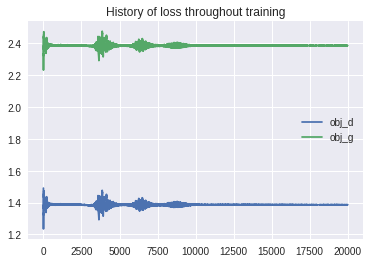

In [22]:
plt.plot(range(TRAIN_ITERS), histd, label='obj_d')
plt.plot(range(TRAIN_ITERS), 1 - histg, label='obj_g')
plt.legend()
plt.title('History of loss throughout training')